In [1]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import copernicusmarine as cm
import tensorflow as tf
from SRGAN_funcs import load_and_combine_channels
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Load data

In [2]:
path = os.getcwd()
path

'E:\\Documents\\MING\\Tesis\\Proyecto'

In [3]:
os.makedirs("data", exist_ok=True)

def download(start_date, end_date, file_name):
    
    try:
        data = netCDF4.Dataset(f'data/{file_name}.nc', 'r')
    except:
        cm.subset(
            dataset_id="cmems_mod_glo_phy_anfc_0.083deg_PT1H-m",
            variables=["thetao", "uo", "vo", "zos"],
            minimum_longitude=-96.92524957370406, # west
            maximum_longitude=-90.69459354433525, # east
            minimum_latitude=20.825606179962158, # south
            maximum_latitude=26.883188430737402, # north
            start_datetime=start_date,
            end_datetime=end_date,
            minimum_depth=0.49402499198913574,
            maximum_depth=0.49402499198913574,
            output_directory='data',
            output_filename=f"{file_name}.nc", 
            overwrite=True
        )
    
        data = netCDF4.Dataset(f'data/{file_name}.nc', 'r')

    return data

In [4]:
data = download("2022-06-01T12:00:00", "2025-06-01T12:00:00", "all_data")

In [5]:
keys = data.variables.keys()
keys

dict_keys(['thetao', 'uo', 'vo', 'zos', 'depth', 'latitude', 'longitude', 'time'])

# Extract features

In [6]:
temp, vx, vy, ssh, _, lat, lng, _ = [np.array(data[var]) for var in data.variables.keys()]

In [7]:
vx.shape

(26305, 1, 73, 75)

In [8]:
data = {"temp": temp, "vx": vx, "vy": vy, "ssh": ssh}

# Temporal subsample

We keep 1 measurement per day

In [9]:
# Downsample time
for var in data:
    arr = data[var][::24]
    arr = arr.squeeze(axis=1) # remove extra axis
    data[var] = arr

# Data augmentation + croping

In [10]:
def get_crop_coords(t, h, w, crop_size=64, num_crops=1, seed=None):
    """
    Generate consistent random crop coordinates for each timestep.

    Args:
        t (int): Number of timesteps.
        h (int): Height (latitude) of the spatial grid.
        w (int): Width (longitude) of the spatial grid.
        crop_size (int, optional): Size of the square crop. Default is 64.
        num_crops (int, optional): Number of crops to generate per timestep. Default is 1.
        seed (int or None, optional): Random seed for reproducibility. Default is None.

    Returns:
        List[Tuple[int, int, int]]: A list of (timestep_index, lat_start, lon_start) tuples
                                    specifying the crop positions.
    """
    rng = np.random.default_rng(seed) # random number generator
    coords = []

    for i in range(t): # for each timestep
        for _ in range(num_crops): # if num_crops>1, data augmentation takes place
            lat_start = rng.integers(0, h - crop_size + 1)
            lon_start = rng.integers(0, w - crop_size + 1)
            coords.append((i, lat_start, lon_start)) 
    
    return coords

def apply_crops(arr, coords, crop_size=64):
    """
    Apply a list of crop coordinates to a 3D array (time, height, width).

    Args:
        arr (np.ndarray): Input array of shape (t, h, w) to crop.
        coords (List[Tuple[int, int, int]]): List of crop coordinates 
            in the form (timestep_index, lat_start, lon_start).
        crop_size (int, optional): Size of the square crop. Default is 64.

    Returns:
        np.ndarray: Cropped array of shape (len(coords), crop_size, crop_size).
    """
    crops = []
    # if data augmentation was performed, 
    # there will be multiple coords with the same i.
    for i, lat_start, lon_start in coords:
        crop = arr[i, lat_start:lat_start + crop_size, lon_start:lon_start + crop_size]
        crops.append(crop)
    return np.stack(crops)

In [11]:
# Get crop coordinates from any one variable
t, h, w = data["temp"].shape
crop_coords = get_crop_coords(t, h, w, crop_size=64, num_crops=3, seed=42)

# Apply same crop coordinates to all variables
for var in data:
    arr = data[var]
    data[var] = apply_crops(arr, crop_coords, crop_size=64)

# Standardize

In [12]:
scalers = {}
train_time = 3*365 

for var in ['temp', 'vx', 'vy', 'ssh']:
    arr = data[var]  # shape: (time, 64, 64)
    train = arr[:train_time]  # full 3 years for training
    n, h, w = train.shape

    scaler = StandardScaler()
    scaler.fit(train.reshape(-1, 1))  # flatten for fitting.
    scalers[var] = scaler


for var in data:
    arr = data[var]
    n, h, w = arr.shape
    # flatten to scale, then unflatten
    data[var] = scalers[var.split('_')[0]].transform(arr.reshape(-1, 1)).reshape(n, h, w)

# Save scalers to un-standardize predictions
os.makedirs("scalers", exist_ok=True)

for var, scaler in scalers.items():
    joblib.dump(scaler, f"scalers/{var}.pkl")

# Split data

In [14]:
split_data = {}

val_time = train_time + 3*365//2

for var in data:
    split_data[f"{var}_train"] = data[var][:train_time]
    split_data[f"{var}_val"] = data[var][train_time:val_time]
    split_data[f"{var}_test"] = data[var][val_time:]

In [15]:
split_data['temp_train'].shape

(1095, 64, 64)

# Gaussian blur + spatial subsampling

In [16]:
def blur_and_downsample(arr, sigma=1.0, factor=4):
    """
    Apply Gaussian blur and downsample by a factor to each 2D image.

    Parameters:
        arr: np.ndarray of shape (n, h, w)
        sigma: float or sequence, standard deviation for Gaussian blur
        factor: int, downsampling factor (must divide h and w evenly)

    Returns:
        low_res: np.ndarray of shape (n, h//factor, w//factor)
    """
    n, h, w = arr.shape
    assert h % factor == 0 and w % factor == 0, "Size must be divisible by factor."

    blurred = np.empty_like(arr)
    for i in range(n):
        blurred[i] = gaussian_filter(arr[i], sigma=sigma)

    # Downsample by taking every `factor` pixel
    low_res = blurred[:, ::factor, ::factor]
    return low_res

In [17]:
split_data_lr = {}

for key, value in split_data.items():
    split_data_lr[key] = blur_and_downsample(value, sigma=1.0, factor=4)

# Save data 

In [18]:
def save_data(data, path, prefix):
    os.makedirs(path, exist_ok=True)
    for i in range(data.shape[0]):
        filename = os.path.join(path, f"{prefix}_{i}.npy")
        np.save(filename, data[i])

In [19]:
path = os.path.join(os.getcwd(), "data")

for key, val in split_data.items():
    var, split = key.split("_")
    save_data(val, f"{path}/{split}/HR/{var}/", var)

for key, val in split_data_lr.items():
    var, split = key.split("_")
    save_data(val, f"{path}/{split}/LR/{var}/", var)

In [20]:
np.save(f"{path}/lat.npy", lat)
np.save(f"{path}/lng.npy", lng)

# Distributions

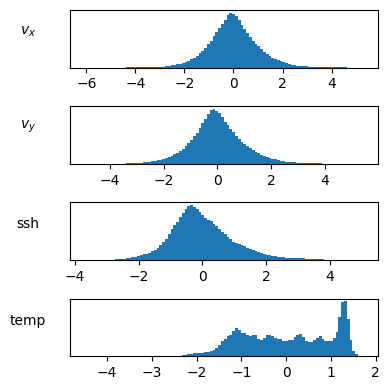

In [21]:
temp = split_data["temp_train"]
ssh = split_data["ssh_train"]
vx = split_data["vx_train"]
vy = split_data["vy_train"]

fig, axs = plt.subplots(4, 1, figsize=(4, 4))

axs[0].hist(vx.flatten(), bins=100)
axs[0].set_ylabel(r"$v_x$", rotation=0, labelpad=30)
axs[0].set_yticks([])

axs[1].hist(vy.flatten(), bins=100)
axs[1].set_ylabel(r"$v_y$", rotation=0, labelpad=30)
axs[1].set_yticks([])

axs[2].hist(ssh.flatten(), bins=100)
axs[2].set_ylabel("ssh", rotation=0, labelpad=30)
axs[2].set_yticks([])

axs[3].hist(temp.flatten(), bins=100)
axs[3].set_ylabel("temp", rotation=0, labelpad=30)
axs[3].set_yticks([])

plt.tight_layout()

In [22]:
# Define folder paths for training HR and LR data.
train_hr_folder = os.path.join(os.getcwd(), "data", "train", "HR")
train_lr_folder = os.path.join(os.getcwd(), "data", "train", "LR")

# Load and combine channels for HR and LR images.
hr_images = load_and_combine_channels(train_hr_folder, "ssh")
lr_images = load_and_combine_channels(train_lr_folder, "ssh")

In [23]:
# Create a TensorFlow dataset.
batch_size = 32  # Set your desired batch size
dataset = tf.data.Dataset.from_tensor_slices((lr_images, hr_images))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

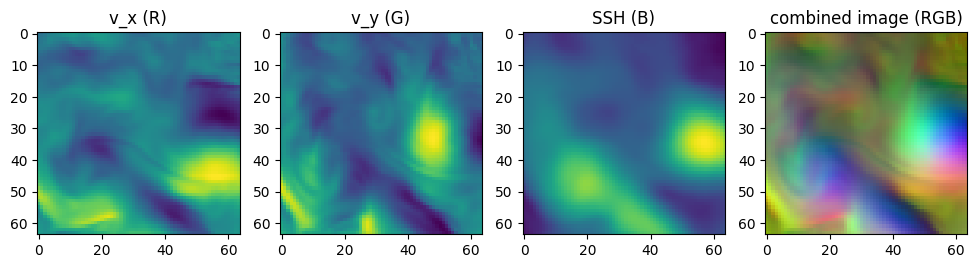

In [24]:
for lr_batch, hr_batch in dataset.take(1):
    # Extract the first HR image from the batch and convert to a NumPy array
    first_hr_image = hr_batch[0].numpy()
    img = first_hr_image[..., :3]
    v_max = np.max(img[..., :2])
    v_min = np.min(img[..., :2])
    img[..., :2] = (img[..., :2] - v_min)/(v_max - v_min)
    temp_max = np.max(img[..., -1])
    temp_min = np.min(img[..., -1])
    img[..., -1] = (img[..., -1] - temp_min)/(temp_max - temp_min)
    
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    axs[0].imshow(img[..., 0])
    axs[0].set_title("v_x (R)")
    axs[1].imshow(img[..., 1])
    axs[1].set_title("v_y (G)")
    axs[2].imshow(img[..., 2])
    axs[2].set_title("SSH (B)")
    axs[3].imshow(img)
    axs[3].set_title("combined image (RGB)")